In [ ]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from utils.engine import train_one_epoch, evaluate

## Configure Path

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

DATABASE_BASE = "/home/mirap/0_DATABASE/1_sperm_acrosome_reaction/1_AR_400/"
train_csv_path = DATABASE_BASE + "csv/exp_set_1_train_labels.csv"
test_csv_path = DATABASE_BASE + "csv/exp_set_1_val_labels.csv"
train_image_path = DATABASE_BASE + "set1"
test_image_path = DATABASE_BASE + "5_folds/fold_5"
model_save_path = "trained_model/1_AR_400/v1/"
model_save_name = model_save_path + "ssd300_vgg16"

## Check data

In [3]:
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape)
train_csv.head()

(2848, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(100).JPG,1200,800,AR,340,748,382,780
1,190305_D253_MO_400X_(100).JPG,1200,800,AR,681,654,733,685
2,190305_D253_MO_400X_(100).JPG,1200,800,AR,924,642,962,671
3,190305_D253_MO_400X_(100).JPG,1200,800,AR,96,240,137,278
4,190305_D253_MO_400X_(100).JPG,1200,800,AR,496,530,540,557


In [4]:
test_csv = pd.read_csv(test_csv_path)
print(test_csv.shape)
test_csv.head()

(748, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(1).JPG,1200,800,AR,60,350,103,400
1,190305_D253_MO_400X_(1).JPG,1200,800,AR,92,1,144,43
2,190305_D253_MO_400X_(1).JPG,1200,800,AR,556,200,602,263
3,190305_D253_MO_400X_(1).JPG,1200,800,AR,298,270,340,317
4,190305_D253_MO_400X_(1).JPG,1200,800,AR,215,192,252,233


In [5]:
categories = train_csv["class"].unique()
print(categories)

['AR' 'Non_AR']


## Encoding classes to integers
* 0 is for background

In [6]:
# Encoding functions
class LabelMap:
    def __init__(self, categories):
        self.map_dict = {}
        self.reverse_map_dict={}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat
    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df
    def inverse(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

In [7]:
label_map = LabelMap(categories)

In [8]:
train_csv = label_map.fit(train_csv, "class")
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(100).JPG,1200,800,1,340,748,382,780
1,190305_D253_MO_400X_(100).JPG,1200,800,1,681,654,733,685
2,190305_D253_MO_400X_(100).JPG,1200,800,1,924,642,962,671
3,190305_D253_MO_400X_(100).JPG,1200,800,1,96,240,137,278
4,190305_D253_MO_400X_(100).JPG,1200,800,1,496,530,540,557


In [9]:
test_csv = label_map.fit(test_csv, "class")
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,190305_D253_MO_400X_(1).JPG,1200,800,1,60,350,103,400
1,190305_D253_MO_400X_(1).JPG,1200,800,1,92,1,144,43
2,190305_D253_MO_400X_(1).JPG,1200,800,1,556,200,602,263
3,190305_D253_MO_400X_(1).JPG,1200,800,1,298,270,340,317
4,190305_D253_MO_400X_(1).JPG,1200,800,1,215,192,252,233


## Torch Dataset Creation

In [10]:
class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_path, categories, transforms=None,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.image_path = image_path
        self.categories = categories
        self.images = self.df["filename"].unique()
        self.transforms = transforms
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path, self.images[idx])
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        image_data = self.df[self.df['filename'] == self.images[idx]]
        labels = torch.as_tensor(image_data["class"].values, dtype=torch.int64)
        xmins = image_data["xmin"].values
        ymins = image_data["ymin"].values
        xmaxs = image_data["xmax"].values
        ymaxs = image_data["ymax"].values
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"],dtype=torch.float32)
        return torch.as_tensor(img, dtype=torch.float32), target
    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data["width"].values[0], image_data["height"].values[0]

## Data Augmentation

In [11]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [12]:
transform_test = A.Compose([
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## Dataloader creation

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_dataset = AnimalDataset(train_csv, train_image_path, categories, transform_train)
test_dataset = AnimalDataset(test_csv, test_image_path, categories, transform_test)

In [15]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=collate_fn)
    
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

## Plot images from dataloader

In [16]:
def plot_images(images, targets):
    for image, target in zip(images, targets):
        sample = image.permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        boxes = target["boxes"].cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        ax.set_axis_off()
        ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train batch


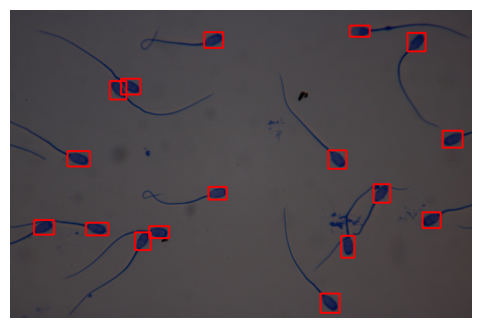

In [17]:
images, targets = next(iter(data_loader_train))
print("Train batch")
plot_images(images, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test batch


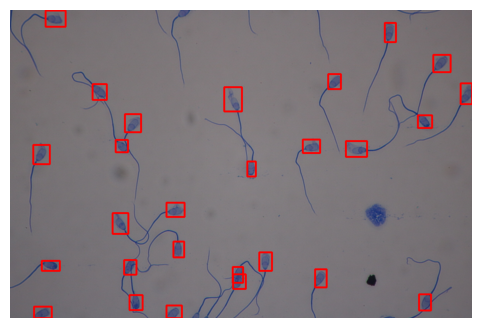

In [18]:
images, targets = next(iter(data_loader_test))
print("test batch")
plot_images(images, targets)

## Training

import model from torchvision library </br>
https://pytorch.org/vision/0.11/models.html

In [19]:
num_classes = len(categories)+1 # add background class

In [25]:
import torchvision.models.detection as torch_det

# detection_model = torch_det.fasterrcnn_resnet50_fpn(pretrained=True)

# ... Alternatives ...
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# detection_model = torch_det.ssdlite320_mobilenet_v3_large(num_classes=num_classes)
detection_model = torch_det.ssd300_vgg16(num_classes=num_classes)
# detection_model = torch_det.retinanet_resnet50_fpn(num_classes=num_classes)

adjust classes

In [ ]:
# for FastRCNN series... 
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = torch_det.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

GPU load try and mount the model

In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [27]:
detection_model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

Training and validation config

In [28]:
def training(model, train_loader, val_loader, epochs=10):
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    for epoch in range(epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=120)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, val_loader, device=device)

In [29]:
history = training(detection_model, data_loader_train, data_loader_test, epochs=10 )

Epoch: [0]  [  0/137]  eta: 0:01:08  lr: 0.000042  loss: 25.7484 (25.7484)  bbox_regression: 5.1582 (5.1582)  classification: 20.5902 (20.5902)  time: 0.5003  data: 0.3349  max mem: 434
Epoch: [0]  [120/137]  eta: 0:00:00  lr: 0.004449  loss: 144.4531 (74.7074)  bbox_regression: 30.0038 (14.1645)  classification: 114.4494 (60.5430)  time: 0.0402  data: 0.0042  max mem: 616
Epoch: [0]  [136/137]  eta: 0:00:00  lr: 0.005000  loss: 113.5278 (79.1226)  bbox_regression: 25.0648 (15.3660)  classification: 87.6223 (63.7566)  time: 0.0325  data: 0.0043  max mem: 616
Epoch: [0] Total time: 0:00:05 (0.0381 s / it)
creating index...
index created!
Test:  [ 0/35]  eta: 0:00:13  model_time: 0.0118 (0.0118)  evaluator_time: 0.0583 (0.0583)  time: 0.3951  data: 0.3232  max mem: 616
Test:  [34/35]  eta: 0:00:00  model_time: 0.0081 (0.0095)  evaluator_time: 0.0139 (0.0407)  time: 0.0392  data: 0.0031  max mem: 616
Test: Total time: 0:00:02 (0.0670 s / it)
Averaged stats: model_time: 0.0081 (0.0095)  ev

Epoch: [4]  [  0/137]  eta: 0:00:51  lr: 0.000500  loss: 5.0056 (5.0056)  bbox_regression: 2.1975 (2.1975)  classification: 2.8081 (2.8081)  time: 0.3772  data: 0.2996  max mem: 616
Epoch: [4]  [120/137]  eta: 0:00:00  lr: 0.000500  loss: 5.3823 (5.3486)  bbox_regression: 2.4166 (2.3708)  classification: 2.9608 (2.9779)  time: 0.0291  data: 0.0037  max mem: 616
Epoch: [4]  [136/137]  eta: 0:00:00  lr: 0.000500  loss: 5.1810 (5.3386)  bbox_regression: 2.2450 (2.3638)  classification: 2.9132 (2.9748)  time: 0.0281  data: 0.0035  max mem: 616
Epoch: [4] Total time: 0:00:04 (0.0334 s / it)
creating index...
index created!
Test:  [ 0/35]  eta: 0:00:12  model_time: 0.0110 (0.0110)  evaluator_time: 0.0560 (0.0560)  time: 0.3558  data: 0.2871  max mem: 616
Test:  [34/35]  eta: 0:00:00  model_time: 0.0082 (0.0138)  evaluator_time: 0.0134 (0.0355)  time: 0.0464  data: 0.0031  max mem: 616
Test: Total time: 0:00:02 (0.0650 s / it)
Averaged stats: model_time: 0.0082 (0.0138)  evaluator_time: 0.013

Epoch: [8]  [120/137]  eta: 0:00:00  lr: 0.000050  loss: 5.2217 (5.2989)  bbox_regression: 2.3381 (2.3416)  classification: 2.9520 (2.9573)  time: 0.0279  data: 0.0032  max mem: 616
Epoch: [8]  [136/137]  eta: 0:00:00  lr: 0.000050  loss: 5.1959 (5.2835)  bbox_regression: 2.2659 (2.3244)  classification: 2.9768 (2.9591)  time: 0.0279  data: 0.0032  max mem: 616
Epoch: [8] Total time: 0:00:04 (0.0327 s / it)
creating index...
index created!
Test:  [ 0/35]  eta: 0:00:12  model_time: 0.0110 (0.0110)  evaluator_time: 0.0570 (0.0570)  time: 0.3624  data: 0.2921  max mem: 616
Test:  [34/35]  eta: 0:00:00  model_time: 0.0082 (0.0116)  evaluator_time: 0.0140 (0.0359)  time: 0.0431  data: 0.0031  max mem: 616
Test: Total time: 0:00:02 (0.0637 s / it)
Averaged stats: model_time: 0.0082 (0.0116)  evaluator_time: 0.0140 (0.0359)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP

## SAVE MODEL

In [ ]:
# Create directory if not exist
os.makedirs(model_save_path, exist_ok=True)

# Save model (parameters only)
torch.save(detection_model.state_dict(), model_save_name+'.pth')